In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from scipy.interpolate import interp1d
from astropy import constants as const
from hmf import MassFunction
from scipy.integrate import quad
from hmf import fitting_functions

## Star Formation Rate

### Star Formation Rate Test

In [2]:
def star_formation_rate(M, sim_num = 1, z = 7):
    '''
    Returns the star-formation rate for a dark-matter halo of a given mass and redshift
    
    Units: M_sun per year
    
    
    Note: Zero-out redshift for now. Other versions of this equation use redshift but the current
          sim that I am basing this equation off of does not use redshift.
    
    https://arxiv.org/pdf/1205.1493.pdf
    
    '''
    
    if sim_num == 1:
        a, b, d, c1, c2 = 2.8, -0.94, -1.7, 1e9, 7e10
        sfr = 2.8e-28 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d
        
    if sim_num == 2:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 1.6e-26 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
        
    if sim_num == 3:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 2.25e-26 * (1.0 + 0.075 * (z-7)) * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
    
    return sfr * u.M_sun / u.year

In [3]:
for i in [1,2,3]:
    print (star_formation_rate(1e8, sim_num=i))

6.414974653808318e-06 solMass / yr
7.832364095536712e-06 solMass / yr
1.10142620093485e-05 solMass / yr


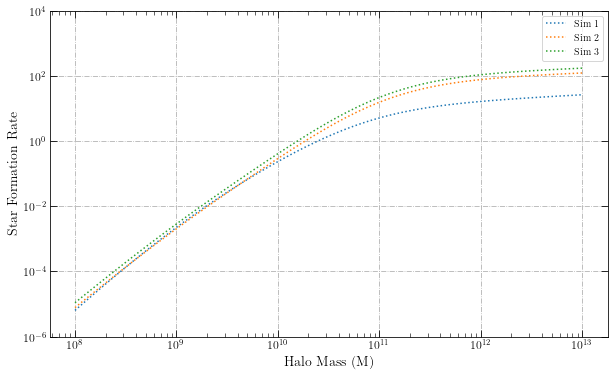

In [4]:
M = np.logspace(8, 13, 100)
plt.figure(figsize=(10,6))

for i in [1, 2, 3]:
    plt.plot(M, star_formation_rate(M, sim_num=i), ':', label = 'Sim {}'.format(i))

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel(r'Halo Mass (M)')
plt.ylabel('Star Formation Rate')
plt.ylim([1e-6, 1e4])
plt.show()

In [5]:
def f_lya(z, C_dust = 3.34, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    
    https://arxiv.org/pdf/1010.4796.pdf
    '''
    return C_dust * 1e-3 * (1.0 + z) ** zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    def alpha(z):
        '''
        Alpha/beta values found in:

        https://arxiv.org/pdf/0903.2045.pdf
        '''
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        a = np.array([2.78e-2, 1.30e-2, 5.18e-3, 3.42e-3, 6.68e-5, 4.44e-5])
        b = np.array([0.105, 0.179, 0.244, 0.262, 0.431, 0.454])
        fa = interp1d(zs, a, kind = 'cubic')
        fb = interp1d(zs, b, kind = 'cubic')
        return (fa(z), fb(z))
    
    a, b = alpha(z)
    return np.exp(-a * M ** b)

def L_gal_rec(M, z, sim_num = 1):
    """
    Luminosity due to galactic recombinations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 1.55e42 * (1 - f_esc(M, z)) * f_lya(z) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal_exc(M, z, sim_num = 1):
    """
    Luminosity due to galactic excitations
    """
    sf_rate = star_formation_rate(M, z = z, sim_num = sim_num)
    return 4.03e41 * f_lya(z) * (1 - f_esc(M, z)) * sf_rate * u.erg / u.s * u.year / u.Msun

def L_gal(M, z, sim_num = 1):
    return L_gal_exc(M, z, sim_num = sim_num) + L_gal_rec(M, z, sim_num = sim_num)

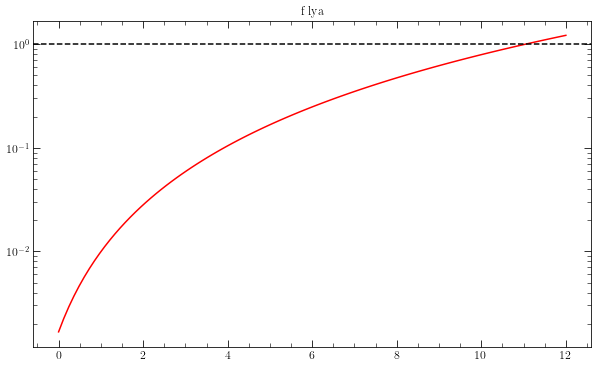

In [6]:
zs = np.linspace(0, 12, 100)
plt.figure(figsize=(10,6))
plt.plot(zs, f_lya(zs, C_dust = 1.67), 'red')
plt.yscale('log')
plt.title('f lya')
plt.axhline(1, color = 'black', linestyle = '--')
plt.show()

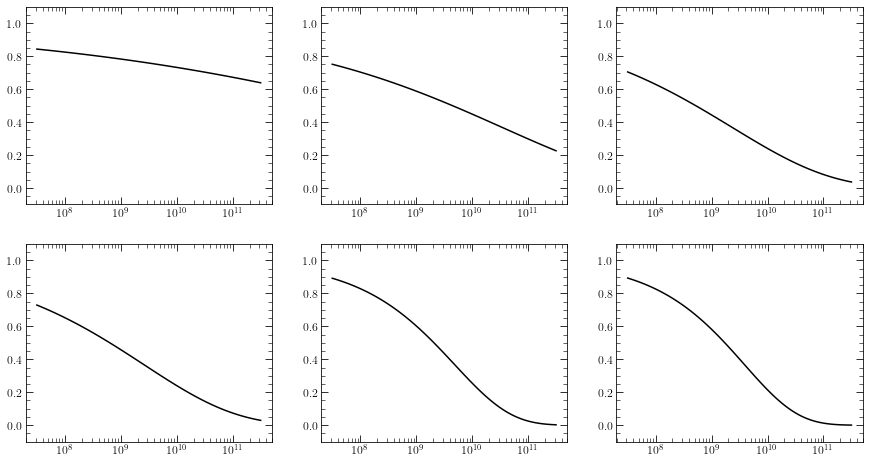

In [7]:
M = np.logspace(7.5, 11.5, 100)
zs = np.array([10.4, 8.2, 6.7, 5.7, 5.0, 4.4])
plt.figure(figsize = (15,8))

for i, z in enumerate(zs):
    plt.subplot(2,3, i+1)
    plt.plot(M, f_esc(M, z = z), 'k')
    plt.xscale('log')
    plt.ylim([-0.1, 1.1])
    
plt.show()

In [8]:
M_min = 1e8
z = 7

for i in range(1,4):
    print (L_gal_rec(M_min, z = z, sim_num=i) + L_gal_exc(M_min, z = z, sim_num=i))

3.752108504865628e+36 erg / s
4.581137342237362e+36 erg / s
6.442224387521289e+36 erg / s


In [9]:
h7 = MassFunction(z = 7, Mmin = 8, Mmax = 13, hmf_model = 'SMT')
h6 = MassFunction(z = 6, Mmin = 8, Mmax = 13, hmf_model = 'SMT')

/usr/local/lib/python3.7/site-packages/hmf/hmf.py:101: UserWarning: hmf is un-tested for redshifts greater than 2 and extreme masses. See https://github.com/steven-murray/HMFcalc/issues/6 for details.
  warnings.warn("hmf is un-tested for redshifts greater than 2 and extreme masses. See https://github.com/steven-murray/HMFcalc/issues/6 for details.")


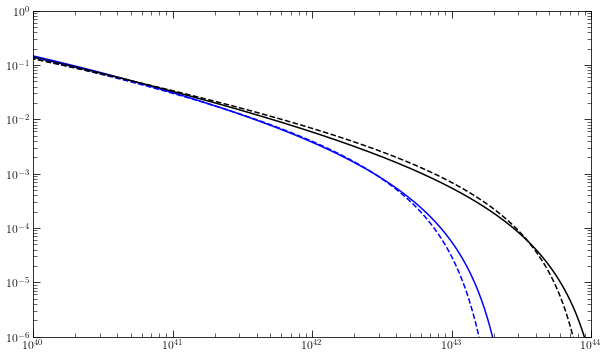

In [10]:
plt.figure(figsize = (10,6))
plt.plot(L_gal(h7.m * cosmo.h, z = 7, sim_num = 1), h7.dndm * h7.m * cosmo.h ** 3, 'b')
plt.plot(L_gal(h7.m * cosmo.h, z = 7, sim_num = 2), h7.dndm * h7.m * cosmo.h ** 3, 'k')
plt.plot(L_gal(h6.m * cosmo.h, z = 6, sim_num = 1), h6.dndm * h6.m * cosmo.h ** 3, 'b--')
plt.plot(L_gal(h6.m * cosmo.h, z = 6, sim_num = 2), h6.dndm * h6.m * cosmo.h ** 3, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-6, 1])
plt.xlim([1e40, 1e44])
plt.show()

## Lyman Alpha Intensity

In [12]:
def H(z):
    '''
    Returns astropy Hubble constant at given redshift
    
    Units: km Mpc^-1 s^-1
    '''
    return cosmo.H(z)

def y(z):
    '''
    wl_lya -> Lyman-alpha wavelength in units of km
    
    Returns value in units of Mpc s
    '''
    l_lya = 1.215e-7 * u.m 
    return l_lya * (1.0 + z) ** 2 / H(z)

def I(z, L = L_gal_rec, n = 5000, sim_num = 1):
    dlog10m = (13 - 8.) / n
    c = y(z) * cosmo.comoving_transverse_distance(z) ** 2 / (4 * np.pi * cosmo.luminosity_distance(z) ** 2)
    h = MassFunction(z = z, Mmin = 8, Mmax = 13, hmf_model = 'SMT', dlog10m = dlog10m)
    M = h.m * cosmo.h
    dM = np.diff(M)
    nu = 2.46e15 / u.s / (1 + z)
    dndm = h.dndm[1:] * u.Mpc ** -3
    return nu * np.sum(dndm * dM * L(M[1:], z, sim_num = sim_num) * c)
    

In [13]:
zs = np.linspace(7, 10.4, 15)
nu_I = np.zeros_like(zs)
nu_I_sim_2 = np.zeros_like(zs)

In [14]:
for i, z in enumerate(zs):
    if i % 3 == 0:
        print (i)
    nu_I[i] = I(z = z, L = L_gal, sim_num=1).to(u.erg / u.cm ** 2 / u.s).value
    nu_I_sim_2[i] = I(z = z, L = L_gal, sim_num=2).to(u.erg / u.cm ** 2 / u.s).value

0
3
6
9
12


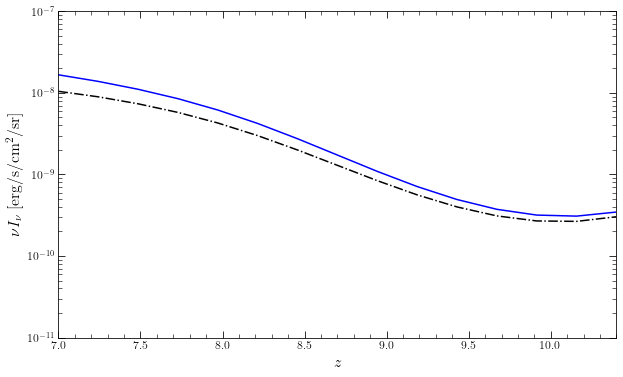

In [15]:
plt.figure(figsize = (10, 6))
plt.plot(zs, nu_I, 'k-.')
plt.plot(zs, nu_I_sim_2, 'b')
plt.xlim([7,10.4])
plt.ylim([1e-11, 1e-7])
plt.yscale('log')
plt.ylabel(r'$\nu I_{\nu}$ [erg/s/cm$^2$/sr]', fontsize = 16)
plt.xlabel(r'$z$', fontsize = 16)
plt.show()